
# Web Graph Analysis — Finding Important Nodes (Wikipedia Demo)

**Goal:** Build a small directed web graph (Wikipedia internal links) and analyze node "importance" using **in-degree**, **PageRank**, and **betweenness** centrality.

**Stakeholder & Decisions:** Search/rec systems engineers and community moderators. Findings inform ranking, highlighting hubs, and monitoring bridge nodes.

> ⚠️ Educational demo: we crawl a tiny subset of Wikipedia (polite, depth-limited). For larger graphs, use a static dataset from SNAP or an official dump.


## 1) Setup

In [1]:

import time, re, math, collections
import requests
from bs4 import BeautifulSoup
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 30)
print("Versions → pandas:", pd.__version__)


Versions → pandas: 2.2.3


## 2) Crawl a Tiny Wikipedia Subgraph

In [2]:

BASE = "https://en.wikipedia.org"
HEADERS = {"User-Agent": "inst414-webgraph-demo/1.0 (educational)"}

# Seed pages (change for your topic)
SEEDS = [
    "Data_science",
    "Machine_learning",
    "Artificial_intelligence",
]

# Crawl parameters
MAX_PAGES = 120          # total pages to fetch (keep small for demo)
MAX_PER_PAGE_OUTLINKS = 80  # cap outlinks per page to bound graph size
SLEEP = 0.5              # polite delay between requests (seconds)

def is_valid_article(href: str) -> bool:
    # Only internal article links
    if not href or not href.startswith("/wiki/"):
        return False
    # Skip non-article namespaces (Category:, Help:, File:, Special:, Talk:, Portal:, etc.)
    if ":" in href.split("/wiki/")[1]:
        return False
    # Skip fragments
    if "#" in href:
        return False
    return True

def page_title_from_href(href: str) -> str:
    # Convert "/wiki/Foo_Bar" → "Foo_Bar"
    return href.split("/wiki/")[-1]

def fetch(title: str) -> str:
    url = f"{BASE}/wiki/{title}"
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return r.text

def extract_links(html: str) -> list:
    soup = BeautifulSoup(html, "html.parser")
    out = []
    for a in soup.select("a[href^='/wiki/']"):
        href = a.get("href")
        if is_valid_article(href):
            out.append(page_title_from_href(href))
    # de-duplicate while keeping order
    seen = set()
    uniq = []
    for t in out:
        if t not in seen:
            seen.add(t)
            uniq.append(t)
    return uniq[:MAX_PER_PAGE_OUTLINKS]

# BFS-like crawl
G = nx.DiGraph()
queue = collections.deque(SEEDS)
seen = set()

while queue and len(seen) < MAX_PAGES:
    title = queue.popleft()
    if title in seen:
        continue
    try:
        html = fetch(title)
    except Exception as e:
        print("Skip due to fetch error:", title, e)
        continue

    seen.add(title)
    outlinks = extract_links(html)
    for t in outlinks:
        G.add_edge(title, t)
        if t not in seen and len(seen) + len(queue) < MAX_PAGES:
            queue.append(t)

    print(f"Fetched: {title:35s} | outlinks kept: {len(outlinks):3d} | graph: {G.number_of_nodes():5d} nodes, {G.number_of_edges():6d} edges")
    time.sleep(SLEEP)

print(f"\nFinal graph → {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Fetched: Data_science                        | outlinks kept:  80 | graph:    80 nodes,     80 edges
Fetched: Machine_learning                    | outlinks kept:  80 | graph:   157 nodes,    160 edges
Fetched: Artificial_intelligence             | outlinks kept:  80 | graph:   231 nodes,    240 edges
Fetched: Main_Page                           | outlinks kept:  80 | graph:   310 nodes,    320 edges
Fetched: Information_science                 | outlinks kept:  80 | graph:   380 nodes,    400 edges
Fetched: Computer_science                    | outlinks kept:  80 | graph:   447 nodes,    480 edges
Fetched: Comet_NEOWISE                       | outlinks kept:  80 | graph:   523 nodes,    560 edges
Fetched: Astronomical_survey                 | outlinks kept:  80 | graph:   599 nodes,    640 edges
Fetched: Space_telescope                     | outlinks kept:  80 | graph:   672 nodes,    720 edges
Fetched: Wide-field_Infrared_Survey_Explorer | outlinks kept:  80 | graph:   739 nodes,    

## 3) Basic Sanity Checks

In [3]:

assert G.number_of_nodes() > 0 and G.number_of_edges() > 0, "Graph is empty."
example_edge = next(iter(G.edges()))
assert isinstance(example_edge, tuple) and len(example_edge) == 2
print("Sanity checks passed ✅")


Sanity checks passed ✅


## 4) Centrality: Defining 'Importance'

In [4]:

# In-degree centrality
in_degs = dict(G.in_degree())
in_deg_series = pd.Series(in_degs, name="in_degree").sort_values(ascending=False)

# PageRank
pr = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06)
pr_series = pd.Series(pr, name="pagerank").sort_values(ascending=False)

# Betweenness on largest weakly connected component
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()
btw = nx.betweenness_centrality(H, normalized=True)
btw_series = pd.Series(btw, name="betweenness").sort_values(ascending=False)

summary = (pd.concat([in_deg_series, pr_series, btw_series], axis=1)
             .fillna(0)
             .sort_values(["pagerank","in_degree","betweenness"], ascending=False))
summary.head(10)


,in_degree,pagerank,betweenness
Main_Page,119,0.000595,0.000455
Machine_learning,51,0.000388,0.003694
Data_mining,42,0.000346,0.000550
Regression_analysis,35,0.000318,0.000562
Doi_(identifier),23,0.000316,0.000363
Cluster_analysis,33,0.000312,0.000144
Deep_learning,30,0.000309,0.000000
Supervised_learning,29,0.000307,0.000440
Statistical_classification,30,0.000305,0.000604
Logistic_regression,29,0.000303,0.000000


## 5) Identify Top Nodes (at least 3)

In [5]:

top_in = in_deg_series.head(10).reset_index().rename(columns={"index":"node"})
top_pr = pr_series.head(10).reset_index().rename(columns={"index":"node"})
top_bt = btw_series.head(10).reset_index().rename(columns={"index":"node"})

display(top_in.head(5))
display(top_pr.head(5))
display(top_bt.head(5))

top_in.to_csv("table_top_in_degree.csv", index=False)
top_pr.to_csv("table_top_pagerank.csv", index=False)
top_bt.to_csv("table_top_betweenness.csv", index=False)
summary.head(25).to_csv("table_summary_top25.csv", index=False)
print("Saved CSV tables.")


,node,in_degree
0,Main_Page,119
1,Machine_learning,51
2,Data_mining,42
3,Regression_analysis,35
4,Cluster_analysis,33


,node,pagerank
0,Main_Page,0.000595
1,Machine_learning,0.000388
2,Data_mining,0.000346
3,Regression_analysis,0.000318
4,Doi_(identifier),0.000316


,node,betweenness
0,Data_science,0.011063
1,Dimensionality_reduction,0.005116
2,Data_analysis,0.004422
3,Data_visualization,0.004106
4,Machine_learning,0.003694


Saved CSV tables.


## 6) Figures

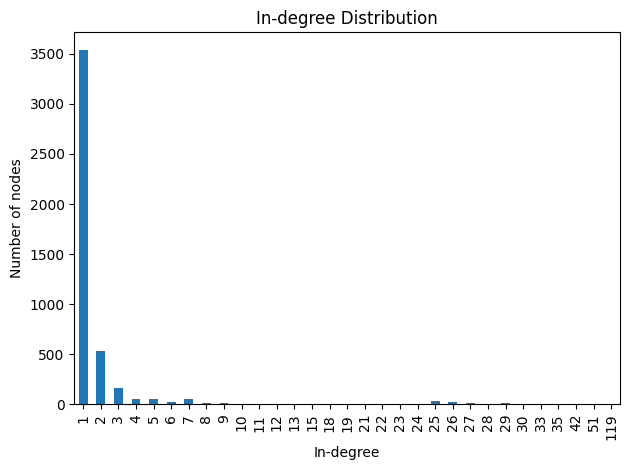

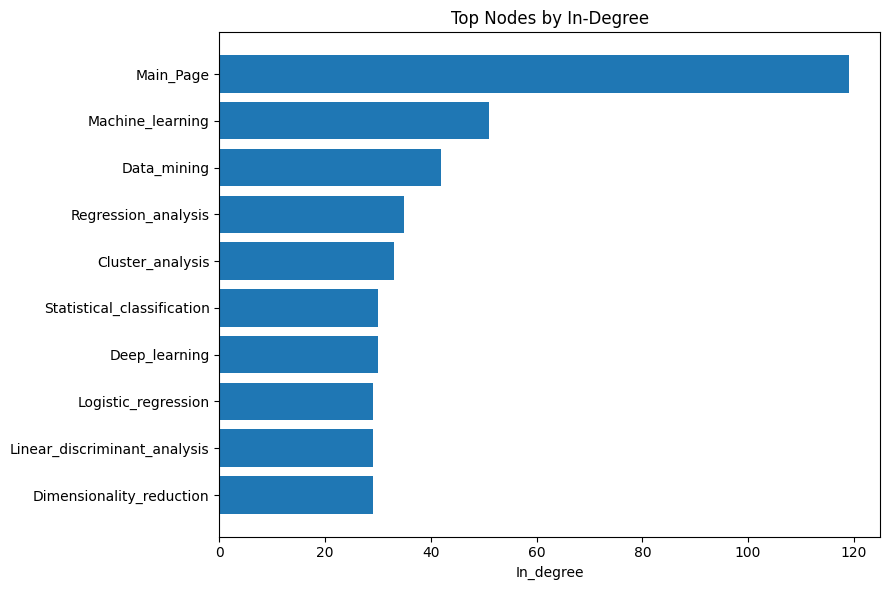

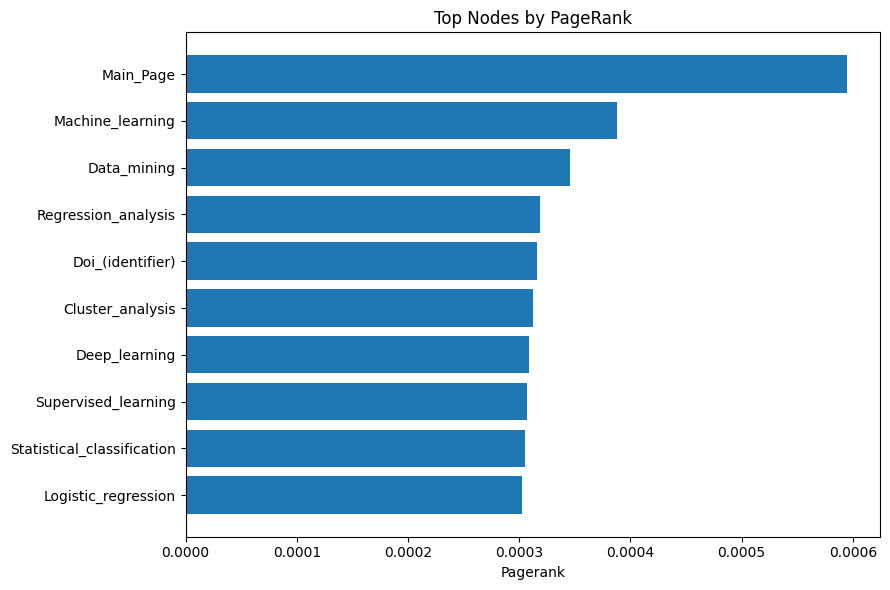

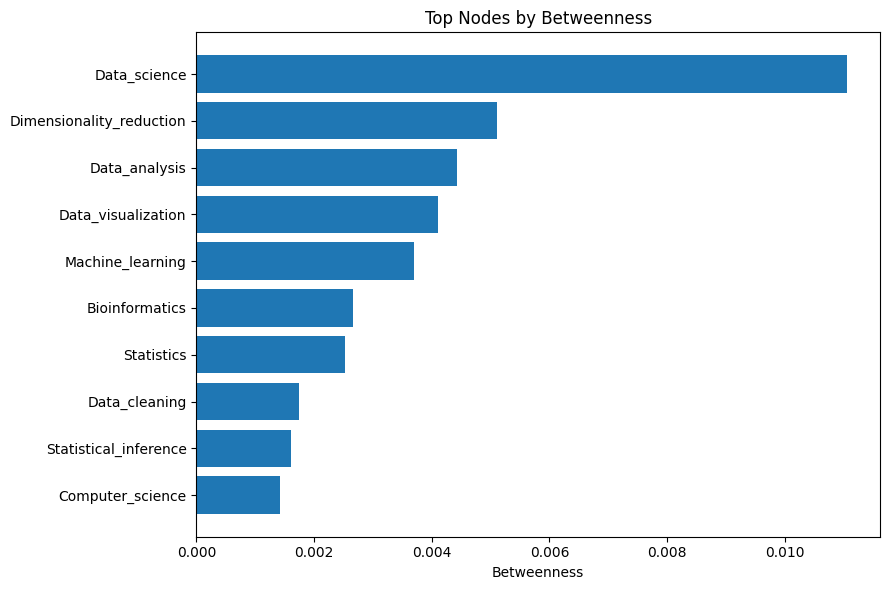

In [6]:

plt.figure()
pd.Series(dict(G.in_degree())).value_counts().sort_index().plot(kind="bar")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes")
plt.title("In-degree Distribution")
plt.tight_layout()
plt.savefig("fig_indegree_distribution.png", dpi=180)
plt.show()

def barh_from_df(df, value_col, title, outfile):
    plt.figure(figsize=(9,6))
    plt.barh(df["node"][::-1], df[value_col][::-1])
    plt.title(title)
    plt.xlabel(value_col.capitalize())
    plt.tight_layout()
    plt.savefig(outfile, dpi=180)
    plt.show()

barh_from_df(top_in.head(15), "in_degree", "Top Nodes by In-Degree", "fig_top_in_degree.png")
barh_from_df(top_pr.head(15), "pagerank", "Top Nodes by PageRank", "fig_top_pagerank.png")
barh_from_df(top_bt.head(15), "betweenness", "Top Nodes by Betweenness", "fig_top_betweenness.png")


## 7) Validation

In [7]:

pr_sum = float(pr_series.sum())
print("PageRank sum ≈", pr_sum)
assert abs(pr_sum - 1.0) < 1e-4, "PageRank does not sum to ~1"

assert (btw_series.ge(0) & btw_series.le(1)).all()

self_loops = list(nx.selfloop_edges(G))
print("Self-loops:", len(self_loops))
if self_loops:
    G.remove_edges_from(self_loops)

print("Validation passed ✅")


PageRank sum ≈ 0.9999999999999725
Self-loops: 110
Validation passed ✅


## 8) Notes on Reproducibility & Limitations


- **Politeness:** Tiny crawl with delay; change seeds and limits cautiously.
- **Partial graph:** Results depend on starting pages and cap sizes.
- **Metric bias:** PageRank favors well-linked pages; betweenness can be noisy.
- **AI assistance:** Verify outputs by running the notebook; assertions help catch errors.
